In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [38]:
# New timing data for multiple UE scenarios (seconds)
# Removed column: 'UEs register'
# Columns now: UEs, xApp Monitoring, Monitoring System, rApp Energy Optimization, Handover Process
import numpy as np

raw_data = [
    # UEs, xApp Monitoring, Monitoring System, rApp Energy Optimization, Handover Process
    (256,   0.254, 222.16, 1.501, 42),
    (512,   0.227, 449.87, 1.515, 132),
    (1024,  0.420, 912.66, 1.768, 279),
    (2048,  0.440,   0.00, 2.000, 1087),
    (4096,  0.805,   0.00, 2.950, 837),
    (8192,  1.920,   0.00, 5.793, 1004),
]

columns = ["UEs", "xApp Monitoring", "Monitoring System", "rApp Energy Optimization", "Handover Process"]
df = pd.DataFrame(raw_data, columns=columns)

# Ensure numeric types
df[columns[1:]] = df[columns[1:]].apply(pd.to_numeric)

# Totals per UE scenario for percentage calculations
df['Total'] = df[columns[1:]].sum(axis=1)

processes = columns[1:]


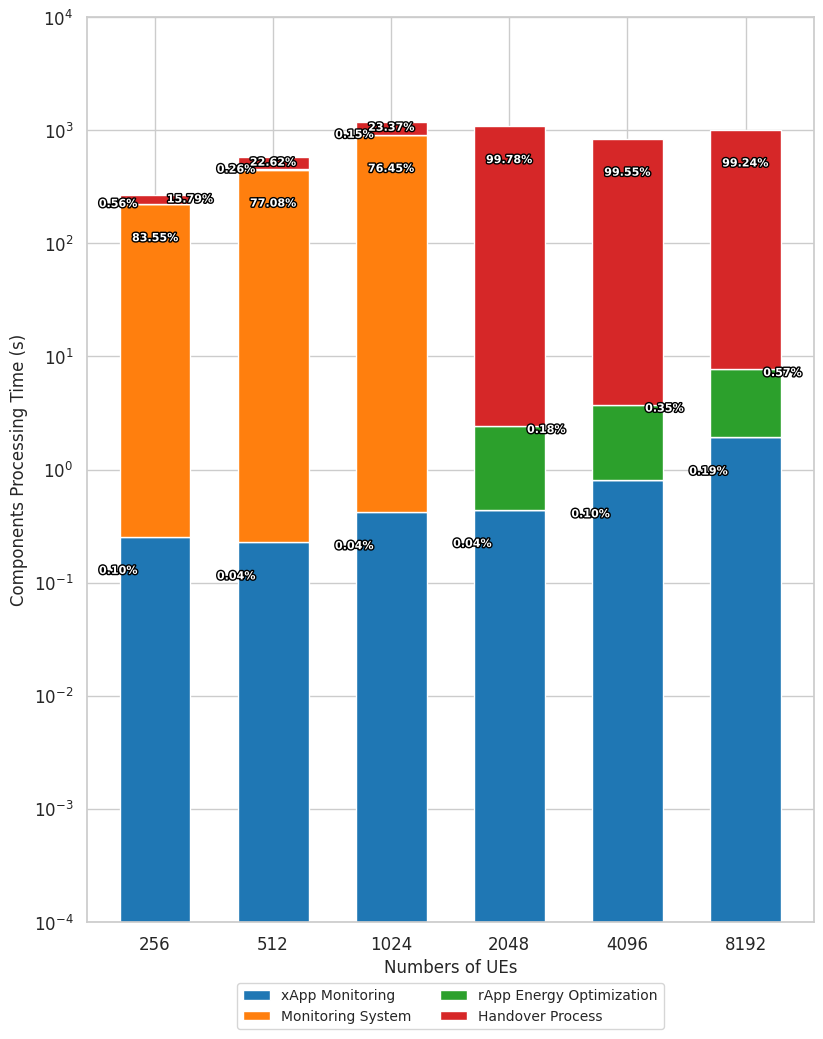

In [39]:
# Set seaborn style
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(12*0.7, 15*0.7))

colors = sns.color_palette("tab10", len(processes))
bar_width = 0.6

# Build stacked bars
bottom = np.zeros(len(df))
for i, proc in enumerate(processes):
    values = df[proc].values
    ax.bar(df['UEs'].astype(str), values, bottom=bottom, color=colors[i], label=proc, width=bar_width)
    bottom += values

base_fontsize = 10
annotation_fontsize = 8  # uniform annotation font size
from matplotlib import patheffects as pe

def fmt_pct(p):
    return f"{p:.2f}%"  # always two decimals

# Alternate left/right placement to reduce horizontal overlap
for x_idx, ue in enumerate(df['UEs']):
    total = df.loc[df['UEs'] == ue, 'Total'].iloc[0]
    if total <= 0: continue
    cum = 0.0
    seg_index = 0
    placed_centers = []
    min_gap = total * 0.015  # vertical spacing
    for proc, color in zip(processes, colors):
        val = df.loc[df['UEs'] == ue, proc].iloc[0]
        start = cum
        end = cum + val
        if val > 0:
            pct = val / total * 100 if total > 0 else 0
            center = start + val/2
            # vertical nudge to avoid collisions (simple upward push)
            for _ in range(8):
                if all(abs(center - c) >= min_gap for c in placed_centers):
                    break
                center += min_gap * 0.6
                if center > end - 0.1*val:
                    center = end - 0.1*val
                    break
            placed_centers.append(center)
            label = fmt_pct(pct)
            side = -1 if seg_index % 2 == 0 else 1  # alternate
            base_offset = 0.10
            extra = 0.05 if (val / total) < 0.02 else 0
            offset = (base_offset + extra) * side
            x_text = x_idx + offset
            align = 'right' if side < 0 else 'left'
            if (val / total) > 0.20:  # keep large centered
                x_text = x_idx
                align = 'center'
            ax.text(x_text, center, label,
                    ha=align, va='center', fontsize=annotation_fontsize, fontweight='bold', color='white',
                    path_effects=[pe.withStroke(linewidth=2.0, foreground='black')])
            seg_index += 1
        cum = end

ax.set_ylabel('Components Processing Time (s)', fontsize=base_fontsize+2)
ax.set_xlabel('Numbers of UEs', fontsize=base_fontsize+2)
ax.set_yscale('log')
log_ticks = [10**exp for exp in range(-4, 5)]
ax.set_yticks(log_ticks)
ax.tick_params(axis='both', which='major', labelsize=base_fontsize + 2)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.06), ncol=2, fontsize=base_fontsize)
plt.tight_layout()

import os
os.makedirs('out', exist_ok=True)
plt.savefig('out/detailed-times-stacked.pdf', bbox_inches='tight')
plt.savefig('out/detailed-times-stacked.png', dpi=300, bbox_inches='tight')
plt.show()